# Reducing Bias in Machine Learning Models:
### Modeling Part 1: Vanilla Models (Basic and Optimized)


#### Kristen Lo - BrainStation
---

### Table of Contents
- [Introduction](#intro)
- [Part 3: Vanilla Models (Basic and Optimized)](#clean)
    - 1.1: [Housekeeping](#house)
    - 1.2: [Logistic Regression](#log)
    - 1.3: [Decision Tree](#tree)
- [Conclusion](#conc)


---
### <a id = 'intro'></a> Introduction

In this notebook, we will be preparing our vanilla model and then optimizing it for performance. 

There is a need to be able to predict the hospital admission rates for diabetic patients. However, using traditional machine learning models can lead to health disparities caused by biased data which can be related to demographic data (ex. race, age, income, insurance etc). These biases need to be removed prior to modelling so that bias isn't introduced into the model. Building on the work of Raza, S. who aimed to predict, diagnose, and mitigate health disparities in hospital re-admission, my aim is to replicate the study performed by Raza and create my own model that's able to screen for biases and predict admission rates for diabetics visiting the ER. 


Data was sourced from all adult Emergency Department visits from March 2014 - July 2017 from one academic and two community emergency rooms, apart from the Yale New Haven Health system. These visits resulted in either admission to their respective hospital or discharge. 

There are a total of 972 variables that we extracted per patient visit from 560,486 patient visits. 

Courtesy of:
 "Hong WS, Haimovich AD, Taylor RA (2018) Predicting hospital admission at emergency department triage using machine learning. PLoS ONE 13(7): e0201016." (https://doi.org/10.1371/journal.pone.0201016)




-----

## <a id = 'clean'></a> Part 3: Vanilla Modelling (Basic and Optimized) 

---
#### <a id = 'housekeeping'></a> 1.1 HouseKeeping 

Loading the necessary libraries

In [179]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, f1_score, auc
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy.stats import loguniform
import warnings

Loading the clean csv file

In [136]:
health_data = pd.read_csv('Data/clean_health_data_pt2.csv')

In [137]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None) #Show all rows

In [138]:
health_data.head()

,demo_gender,demo_race,disposition,pmh_2ndarymalig,pmh_abdomhernia,pmh_acqfootdef,pmh_acrenlfail,pmh_acutecvd,pmh_acutemi,pmh_acutphanm,pmh_adltrespfl,pmh_alcoholrelateddisorders,pmh_amniosdx,pmh_anemia,pmh_aneurysm,pmh_anxietydisorders,pmh_artembolism,pmh_asppneumon,pmh_asthma,pmh_attentiondeficitconductdisruptivebeha,pmh_biliarydx,pmh_bladdercncr,pmh_blindness,pmh_bnignutneo,pmh_bonectcncr,pmh_bph,pmh_brainnscan,pmh_breastcancr,pmh_breastdx,pmh_brnchlngca,pmh_cardiaarrst,pmh_carditis,pmh_cataract,pmh_chfnonhp,pmh_chrkidneydisease,pmh_coaghemrdx,pmh_coloncancer,pmh_comabrndmg,pmh_complicdevi,pmh_complicproc,pmh_conduction,pmh_contraceptiv,pmh_copd,pmh_coronathero,pmh_crushinjury,pmh_cysticfibro,pmh_deliriumdementiaamnesticothercognitiv,pmh_developmentaldisorders,pmh_diabmelnoc,pmh_diabmelwcm,pmh_disordersusuallydiagnosedininfancych,pmh_diverticulos,pmh_dizziness,pmh_dminpreg,pmh_dysrhythmia,pmh_ecodesadverseeffectsofmedicalcare,pmh_ecodesfall,pmh_ecodesfirearm,pmh_ecodesmotorvehicletrafficmvt,pmh_ecodesotherspecifiedandclassifiable,pmh_encephalitis,pmh_endometrios,pmh_epilepsycnv,pmh_esophcancer,pmh_esophgealdx,pmh_eyeinfectn,pmh_femgenitca,pmh_feminfertil,pmh_fluidelcdx,pmh_fuo,pmh_fxarm,pmh_fxhip,pmh_fxskullfac,pmh_gangrene,pmh_gasduoulcer,pmh_gastritis,pmh_gastroent,pmh_giconganom,pmh_gihemorrhag,pmh_giperitcan,pmh_glaucoma,pmh_goutotcrys,pmh_guconganom,pmh_hdnckcancr,pmh_headachemig,pmh_hemorrpreg,pmh_hodgkinsds,pmh_hrtvalvedx,pmh_htn,pmh_htncomplicn,pmh_htninpreg,pmh_hyperlipidem,pmh_immunitydx,pmh_inducabortn,pmh_infectarth,pmh_influenza,pmh_infmalegen,pmh_intestinfct,pmh_intobstruct,pmh_intracrninj,pmh_jointinjury,pmh_kidnyrnlca,pmh_lateeffcvd,pmh_leukemias,pmh_liveribdca,pmh_lowbirthwt,pmh_lungexternl,pmh_lymphenlarg,pmh_maintchemr,pmh_maligneopls,pmh_meningitis,pmh_menstrualdx,pmh_miscellaneousmentalhealthdisorders,pmh_mooddisorders,pmh_mouthdx,pmh_ms,pmh_multmyeloma,pmh_mycoses,pmh_neoplsmunsp,pmh_nephritis,pmh_nonepithca,pmh_nonhodglym,pmh_nutritdefic,pmh_opnwndextr,pmh_osteoarthros,pmh_osteoporosis,pmh_otaftercare,pmh_otbnignneo,pmh_otbonedx,pmh_otcirculdx,pmh_otcomplbir,pmh_otconntiss,pmh_otdxbladdr,pmh_otdxkidney,pmh_otdxstomch,pmh_otendodsor,pmh_otfemalgen,pmh_othbactinf,pmh_othcnsinfx,pmh_othematldx,pmh_othercvd,pmh_othereardx,pmh_otheredcns,pmh_othereyedx,pmh_othergidx,pmh_othergudx,pmh_otherinjury,pmh_otherpregnancyanddeliveryincludingnormal,pmh_otherscreen,pmh_othfracture,pmh_othheartdx,pmh_othliverdx,pmh_othlowresp,pmh_othmalegen,pmh_othnervdx,pmh_othveindx,pmh_otinflskin,pmh_otitismedia,pmh_otjointdx,pmh_otnutritdx,pmh_otprimryca,pmh_otrespirca,pmh_otupprresp,pmh_otuprspin,pmh_ovariancyst,pmh_pancreascan,pmh_pancreasdx,pmh_paralysis,pmh_parkinsons,pmh_pathologfx,pmh_peripathero,pmh_peritonitis,pmh_personalitydisorders,pmh_phlebitis,pmh_pid,pmh_pleurisy,pmh_pneumonia,pmh_poisnotmed,pmh_precereoccl,pmh_prevcsectn,pmh_prolapse,pmh_prostatecan,pmh_pulmhartdx,pmh_rctmanusca,pmh_rehab,pmh_respdistres,pmh_retinaldx,pmh_rheumarth,pmh_schizophreniaandotherpsychoticdisorde,pmh_screeningandhistoryofmentalhealthan,pmh_septicemia,pmh_sexualinfxs,pmh_shock,pmh_sicklecell,pmh_skininfectn,pmh_skinmelanom,pmh_socialadmin,pmh_spincorinj,pmh_stomchcancr,pmh_substancerelateddisorders,pmh_suicideandintentionalselfinflictedin,pmh_superficinj,pmh_syncope,pmh_teethdx,pmh_testiscancr,pmh_thyroiddsor,pmh_tia,pmh_tonsillitis,pmh_ulceratcol,pmh_ulcerskin,pmh_unclassified,pmh_urinyorgca,pmh_uteruscancr,pmh_uti,pmh_varicosevn,pmh_viralinfect,pmh_whtblooddx,cc_abdominalcramping,cc_abdominaldistention,cc_abdominalpain,cc_abdominalpainpregnant,cc_abnormallab,cc_abscess,cc_addictionproblem,cc_alcoholintoxication,cc_alcoholproblem,cc_allergicreaction,cc_alteredmentalstatus,cc_animalbite,cc_ankleinjury,cc_anklepain,cc_anxiety,cc_arminjury,cc_armpain,cc_assaultvictim,cc_asthma,cc_backpain,cc_bleeding/bruising,cc_bodyfluidexposure,cc_breastpain,cc_breathingdifficulty,cc_burn,cc_cardiacarrest,cc_chestpain,cc_coldlikesymptoms,cc_confusion,cc_co

In [139]:
health_data.shape

(105627, 443)

In [140]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 443 entries, demo_gender to dum_meds__3-plus_hormones
dtypes: int64(443)
memory usage: 357.0 MB


Considering that all of the information is binary, int64 dtype is bloating the file unnecessarily. Let's convert it to int8 to conserve memory and assist in modeling.

In [141]:
# Assuming df is your DataFrame
int64_columns = health_data.select_dtypes(include='int64').columns

# Convert selected columns to int8
health_data[int64_columns] = health_data[int64_columns].astype('int8')

In [142]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 443 entries, demo_gender to dum_meds__3-plus_hormones
dtypes: int8(443)
memory usage: 44.6 MB


As we can see, the memory usage has decreased from 357 mb to 44.6mb. This should be less computationally intensive.

---
#### <a id = 'log'></a> 1.2 Logistic Regression 

Before we can use Log regression, we must make sure that this data satisfies the assumptions. First is to double check if any multicolinearity exists within the data set. 

In [143]:
# Record time
start_time = time.time()

# Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Split to train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for multicollinearity
corr_matrix = X_train.corr()

# Identify highly correlated features
highly_correlated = np.where(np.abs(corr_matrix) > 0.7)

# Show the highly correlated features
features_to_drop = set()
multicollinearity_detected = False

for col1, col2 in zip(*highly_correlated):
    if col1 != col2 and col1 not in features_to_drop:
        features_to_drop.add(col2)
        print(f"Highly correlated features: {X_train.columns[col1]} and {X_train.columns[col2]}")
        multicollinearity_detected = True

# Check if multicollinearity was detected
if not multicollinearity_detected:
    print('No Multicollinearity')

# Record time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Highly correlated features: dum_triage_vital__no_hr_recorded and dum_triage_vital__no_rr_recorded
Highly correlated features: dum_triage_vital__no_hr_recorded and dum_triage_vital__no_temp_recorded
Highly correlated features: dum_huse__no_prior_visits and dum_hist_glucose_median__no_glucose_level_recorded
Highly correlated features: dum_huse__No_prior_admis and dum_hist_glucose_median__no_glucose_level_recorded
Runtime: 26.91 seconds


So there is multicolinearity that exists within the data set, but this makes sense. If a patient didn't have one `triage vital` recorded then it's highly unlikely that they would have the others since triage assessments are all done at the same time. From doing a little bit of digging, it was found that patients that arrive in emergent situations usually don't have `triage vitals` recorded as they are either rushed in by ambulance or taken quickly to treatment. 

Also the glucose level is the last lab value from a previous visit, so it makes sense why no prior admissions and no prior visits would be highly correlated to no glucose level In order to satisfy the assumptions, I will drop these columns from the original data frame. 

In [144]:
features_to_drop = [
    'dum_triage_vital__no_hr_recorded','dum_triage_vital__no_rr_recorded','dum_triage_vital__no_temp_recorded',
    'dum_huse__no_prior_visits','dum_huse__No_prior_admis', 'dum_hist_glucose_median__no_glucose_level_recorded'
]

#drop from the original data frame. 
health_data = health_data.drop(columns=features_to_drop)

---
**Feature Elimination for the Logistic Regression**

Before we can assess any official models, I first want to check if there is any class imbalance. Then I want to do some feature elimination so that only the most important features are selected for modelling. I will do this by finding the best C value and using lasso to find the least important features then drop them. I will then perform a vanilla log reg model (one with no optimizations).

In [145]:
# Check the class distribution before oversampling
print('Class distribution before oversampling:')
print(y_train.value_counts())

Class distribution before oversampling:
disposition
0    45721
1    38780
Name: count, dtype: int64


As we can see here, there is not a pronounced imbalance in classes. Thus, oversampling is not needed. 

---
**Feature Elimination**

Now moving onto feature elimination, RFE attempts has been too computationally intensive. Instead, I will run a lasso regression to do some feature selection, any one that hits 0 first will be removed from the train/test data set. 

In [146]:
health_data.shape[1]

437

We will be starting with 437 features. Let's first see what kind of hyper parameters might help the log model perform better. Let's find the best C value, we will then keep this consistent with out later models.

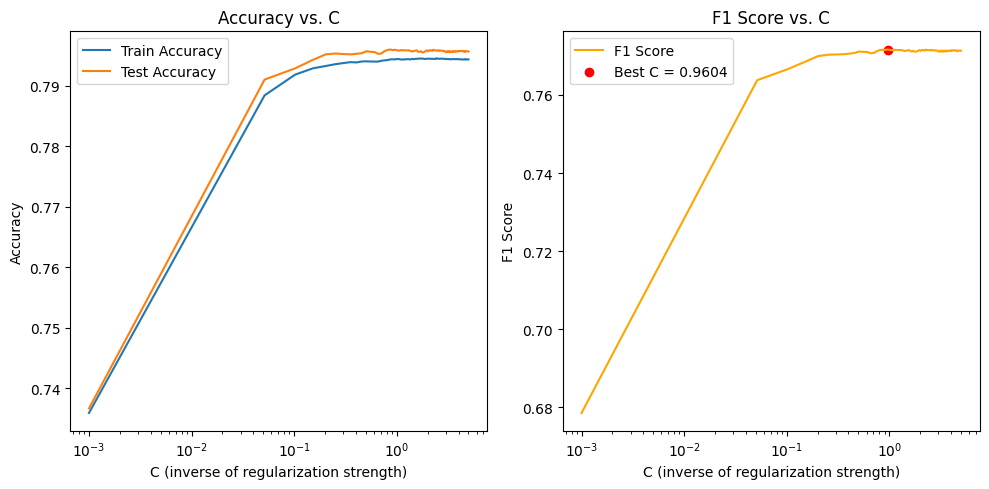

Best C value: 0.9604040404040403
Runtime: 354.93 seconds


In [147]:
# Record time
start_time = time.time()

# Range of C values to test
C_values = np.linspace(0.001, 5, num=100)

# Lists to store accuracy and F1 score
train_accuracy = []
test_accuracy = []
f1_scores = []

# Variable to store the best C value
best_C = None
best_f1_score = 0  # Initialize with a low value

# Loop through each C value
for C_val in C_values:
    # Create a logistic regression model with L1 penalty
    estimator_l1 = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=C_val)

    # Train the model
    estimator_l1.fit(X_train, y_train)

    # Predict on the training set
    y_train_pred = estimator_l1.predict(X_train)

    # Predict on the test set
    y_test_pred = estimator_l1.predict(X_test)

    # Calculate accuracy for training and test sets
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

    # Calculate F1 score for the test set
    f1 = f1_score(y_test, y_test_pred)
    f1_scores.append(f1)

    # Update best C value if needed
    if f1 > best_f1_score:
        best_f1_score = f1
        best_C = C_val

# Plot the results
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(C_values, train_accuracy, label='Train Accuracy')
plt.plot(C_values, test_accuracy, label='Test Accuracy')
plt.xscale('log')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. C')

# Plot F1 score
plt.subplot(1, 2, 2)
plt.plot(C_values, f1_scores, label='F1 Score', color='orange')
plt.scatter(best_C, best_f1_score, color='red', marker='o', label=f'Best C = {best_C:.4f}')
plt.xscale('log')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score vs. C')

plt.tight_layout()
plt.show()

# Print the best C value
print(f'Best C value: {best_C}')

# Record time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))


It was found that the best C value was 0.96 in a range between 0.001 to 5. We will implement this into the next iteration of the log model. This will likely be the final and optimized log model. For the next steps, I will be using lasso in order to drive the columns that have non-zero coefficients, these features have some importance to the model. I will then find the features that are not in this list and drop them. 

In [104]:
health_data.shape[1] #Checking number of rows

411

In [150]:
# Record  time
start_time = time.time()

# Choose logistic regression with L1 regularization (penalty='l1')
estimator_l1 = LogisticRegression(max_iter=1000, C = 0.96, penalty='l1', solver='liblinear')

# Fit logistic regression with L1 regularization on training data 
estimator_l1.fit(X_train, y_train)

# Record time
end_time = time.time()

# Get the coefficients and corresponding feature names
coefficients_l1 = estimator_l1.coef_[0]
feature_names = X.columns

# Get indices of features with non-zero coefficients
non_zero_indices_l1 = np.where(coefficients_l1 != 0)[0]

print(f'The total number of relevant columns is:{non_zero_indices_l1.shape}')  # Find the number of features left after feature selection

# Print the features with non-zero coefficients
print("\nFeatures with Non-Zero Coefficients (L1 Regularization):")
for idx in non_zero_indices_l1:
    print(f'Feature: {feature_names[idx]}, Coefficient: {coefficients_l1[idx]}')

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

The total number of relevant columns is:(423,)

Features with Non-Zero Coefficients (L1 Regularization):
Feature: demo_gender, Coefficient: 0.09071049660528645
Feature: demo_race, Coefficient: 0.1975194877858172
Feature: pmh_2ndarymalig, Coefficient: 0.46813137238408375
Feature: pmh_abdomhernia, Coefficient: 0.05719218456483774
Feature: pmh_acqfootdef, Coefficient: -0.044882959259784756
Feature: pmh_acrenlfail, Coefficient: 0.1844439385732314
Feature: pmh_acutecvd, Coefficient: 0.0854617689883818
Feature: pmh_acutemi, Coefficient: -0.018936697481394205
Feature: pmh_acutphanm, Coefficient: 0.13113855413999945
Feature: pmh_adltrespfl, Coefficient: 0.004659628878123758
Feature: pmh_alcoholrelateddisorders, Coefficient: 0.17400050391513025
Feature: pmh_anemia, Coefficient: 0.14291953593153403
Feature: pmh_aneurysm, Coefficient: 0.038599860021216854
Feature: pmh_anxietydisorders, Coefficient: -0.06352533698745913
Feature: pmh_artembolism, Coefficient: -0.09041164427563281
Feature: pmh_asppn

In [152]:
#Isolate irrelevant columns 
irrelevant_columns = health_data.columns.difference(feature_names[non_zero_indices_l1])

# Ensure 'disposition' is not in the irrelevant columns
irrelevant_columns = irrelevant_columns.difference(['disposition'])

# Display the number of irrelevant columns and their names
num_irrelevant_columns = len(irrelevant_columns)
print(f'Number of irrelevant columns: {num_irrelevant_columns}')
print('Irrelevant columns:', irrelevant_columns)

Number of irrelevant columns: 19
Irrelevant columns: Index(['cc_abdominalcramping', 'cc_addictionproblem', 'cc_detoxevaluation',
       'cc_exposuretostd', 'cc_pain', 'pmh_amniosdx', 'pmh_breastdx',
       'pmh_ecodesotherspecifiedandclassifiable', 'pmh_encephalitis',
       'pmh_guconganom', 'pmh_hemorrpreg', 'pmh_immunitydx', 'pmh_lowbirthwt',
       'pmh_maintchemr', 'pmh_osteoarthros', 'pmh_otdxbladdr',
       'pmh_prevcsectn', 'pmh_superficinj', 'pmh_urinyorgca'],
      dtype='object')


In [153]:
health_data = health_data.drop(columns=irrelevant_columns) #dropping irrelevant columns

In [154]:
health_data.shape[1]#columns have been successfully dropped 

418

After we evaluate the log reg coefficients with lasso, there are a total of 19 features that were removed. We will remove these from the original data frame. 

In [155]:
# Define the features and target variables with changes implemented from feature elimination
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Split to train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now to begin Logistic Regression, I will first run a baseline model with no modifications. I will not scale the data as this is unnecessary for a dataset that is made up of only binary values. However, if it was a different data set, I would scale it as per standard practice. I will include the evaluations for the model as well in the code.

Cross-Validation Scores on Training Set: [0.78545648 0.7887574  0.79325444 0.79011834 0.78656805]
Mean CV Accuracy on Training Set: 0.7888309413434099
Train Accuracy: 0.7917776120992651
Accuracy on Test Set: 0.7928145413234876

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     11348
           1       0.80      0.74      0.77      9778

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126


Confusion Matrix on Test Set:
 [[9528 1820]
 [2557 7221]]


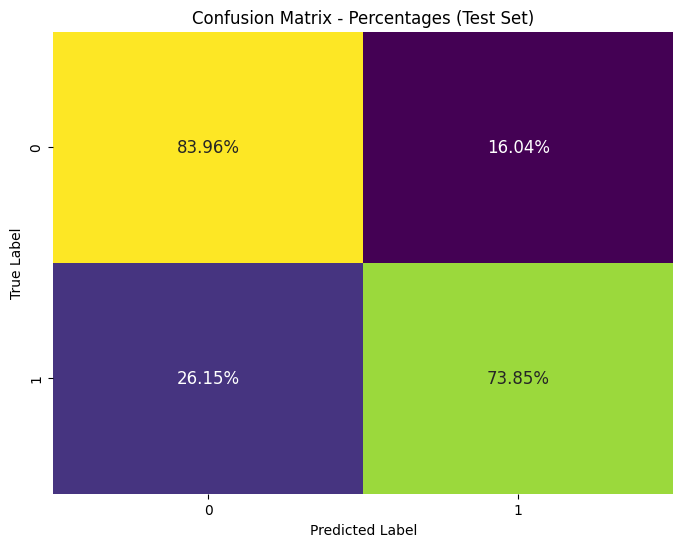

ROC AUC Score: 0.8738760484518742


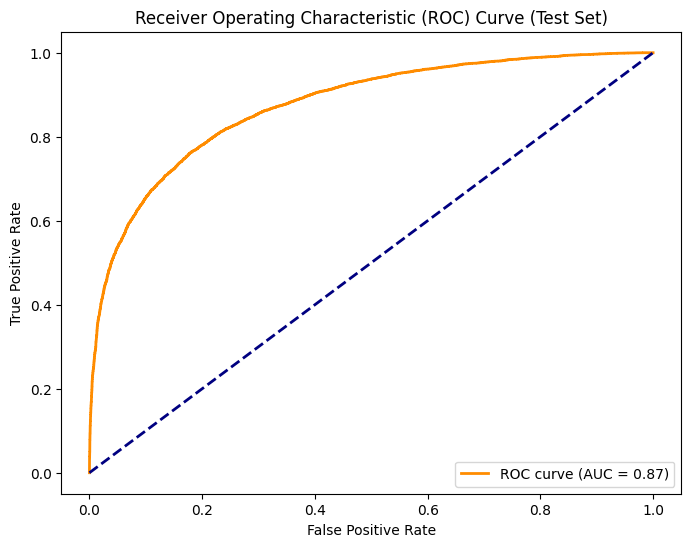

Runtime: 48.23 seconds


In [156]:
# Record time
start_time = time.time()

# Use StratifiedKFold for cross-validation with stratified sampling
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create and fit the Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Perform cross-validation on the training set (X_train, y_train)
cv_scores = cross_val_score(logreg, X_train, y_train, cv=stratified_cv, scoring='accuracy')

# Record time
end_time = time.time()

# Print the cross-validation scores
print('Cross-Validation Scores on Training Set:', cv_scores)
print('Mean CV Accuracy on Training Set:', np.mean(cv_scores))

# Fit the model on the training set
logreg.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = logreg.predict(X_train)

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print('Train Accuracy:', train_accuracy)

# Predictions on the test set
y_pred = logreg.predict(X_test)

# Accuracy Score on the test set
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy on Test Set:', accuracy)

# Classification Report on the test set
print('\nClassification Report on Test Set:\n', classification_report(y_test, y_pred))

# Confusion Matrix on the test set
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix on Test Set:\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix - Percentages (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict probabilities for ROC curve on the test set
y_prob = logreg.predict_proba(X_test)[:, 1]

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score on the test set
roc_auc = roc_auc_score(y_test, y_prob)
print('ROC AUC Score:', roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Cross-Validation Scores on Training Set:
- The cross-validation scores are consistent, ranging from 0.785 to 0.793, with a mean accuracy of approximately 0.789. This suggests that the model is performing consistently well across different folds of the training set.

Train Accuracy:
- The accuracy on the training set is 0.792.

Accuracy on Test Set:
- The accuracy on the test set is 0.793, suggesting that the model generalizes well to new, unseen data.

Classification Report on Test Set:
Precision, recall, and F1-score for both classes (0 and 1) are provided. The model performs well, with good balance between precision and recall for both classes.

Confusion Matrix on Test Set:
The model has a good balance, but there are some misclassifications.

The AUC is 0.87, indicating a good ability of the model to distinguish between the two classes. A higher AUC suggests better discrimination.

Overall, the model appears to perform well, demonstrating good generalization to the test set.

---

Now to try the optimize the logreg model by using Randomsearch (Gridsearch is too computationally intensive)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'C': 3.8672288491177444, 'penalty': 'l2', 'solver': 'liblinear'}
Cross-Validation Scores on Train Set: [0.78604816 0.7891716  0.79343195 0.79017751 0.78680473]
Mean CV Accuracy on Train Set: 0.789126792329434
Train Accuracy: 0.7918722855350824

Test Accuracy: 0.7921991858373568

Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     11348
           1       0.80      0.74      0.77      9778

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126


Confusion Matrix (Test):
 [[9515 1833]
 [2557 7221]]


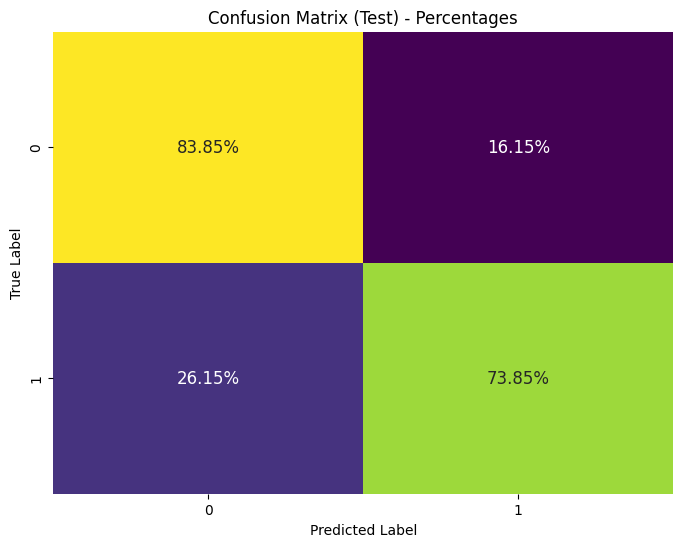

ROC AUC Score: 0.8738329611416449


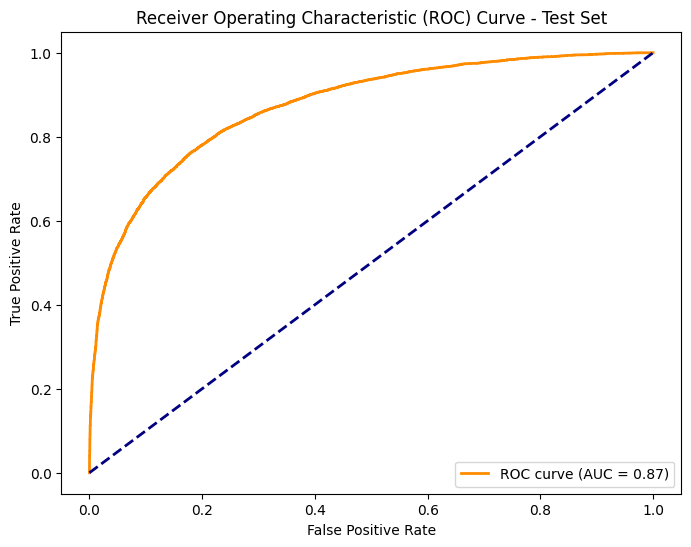

Runtime: 5.46 seconds


In [162]:
#Define the parameter distributions for Randomized Search
param_dist = {
    'C': loguniform(0.001, 1000),  
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear'],  
}

# Create logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(logreg, param_distributions=param_dist, n_iter=50, cv=stratified_cv, scoring='accuracy', random_state=42, verbose=1, n_jobs=-1)

# Perform Randomized Search
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Get the best model
best_logreg_model = random_search.best_estimator_

# Record time
start_time = time.time()

# Perform cross-validation on the best model
cv_scores = cross_val_score(best_logreg_model, X_train, y_train, cv=stratified_cv, scoring='accuracy')

# Print the cross-validation scores
print('Cross-Validation Scores on Train Set:', cv_scores)
print('Mean CV Accuracy on Train Set:', np.mean(cv_scores))

# Fit the best model on the entire training set
best_logreg_model.fit(X_train, y_train)

# Record time
end_time = time.time()

# Make predictions on the training set
y_train_pred = best_logreg_model.predict(X_train)

# Evaluate the best model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
print('Train Accuracy:', train_accuracy)

# Make predictions on the test set
y_test_pred = best_logreg_model.predict(X_test)

# Evaluate the best model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print('\nTest Accuracy:', test_accuracy)

# Classification Reports for test set
print('\nTest Classification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix_test)

# Calculate percentages for the confusion matrix on the test set
conf_matrix_percent_test = conf_matrix_test / conf_matrix_test.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_test, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict probabilities for ROC curve on the test set
y_test_prob = best_logreg_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC score on the test set
roc_auc = roc_auc_score(y_test, y_test_prob)
print('ROC AUC Score:', roc_auc)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Best Hyperparameters: 
- The best hyperparameters found by the Randomized Search are C=3.87, penalty='l2' (ridge regularization), and solver='liblinear'.

Cross-Validation Scores on Train Set: 
- Performance across the 5 folds was consistent between folds and also train accuracy. 

Train Accuracy: 
- The accuracy on the entire training set is 0.7919, suggesting that the model generalizes well to the training data.

Test Accuracy: 
- The accuracy on the test set is 0.7922, which is close to the training accuracy. This suggests that the model is performing well on unseen data.

Test Classification Report: 
- The precision, recall, and F1-score for both classes (0 and 1) are provided. The weighted average F1-score is 0.79, indicating a good balance between precision and recall.

Overall, the results suggest that the logistic regression model with the identified hyperparameters is effective in predicting the disposition of the data, achieving good accuracy and balanced performance on both training and test sets..

---

Now, let's understand what features are most important to the log model. I will map the top 20 positive and negative features by the size of their coefficients. 

Top 20 Positive Features:
cc_lethargy: 1.1792171464666004
cc_confusion: 1.2210311333896717
cc_gibleeding: 1.2224240217602382
cc_dyspnea: 1.222938876796011
dum_triage_vital__critical_hr: 1.2251220076882339
cc_withdrawal-alcohol: 1.2306596510975785
cc_feverimmunocompromised: 1.2571400678513007
cc_fever-75yearsorolder: 1.362233987351954
cc_lossofconsciousness: 1.3635441065246638
cc_neurologicproblem: 1.4772009912207784
cc_alteredmentalstatus: 1.532094073395121
dum_meds__1-to-2_hormones: 1.5413574505158623
dum_meds__3-plus_hormones: 1.6960047335395578
cc_unresponsive: 1.859136353049744
cc_overdose-intentional: 1.8594361916151538
cc_fulltrauma: 2.0923409090695273
dum_meds__1-to-2_antihyperglycemics: 2.2361163417980605
cc_strokealert: 2.6281493520329455
dum_meds__3-to-6_antihyperglycemics: 2.846532528282009
cc_respiratorydistress: 3.338848307366643

Top 20 Negative Features:
cc_handinjury: -1.7132465124606446
cc_extremitylaceration: -1.7579827904618723
cc_skinirritation: -1.864398928853056
c

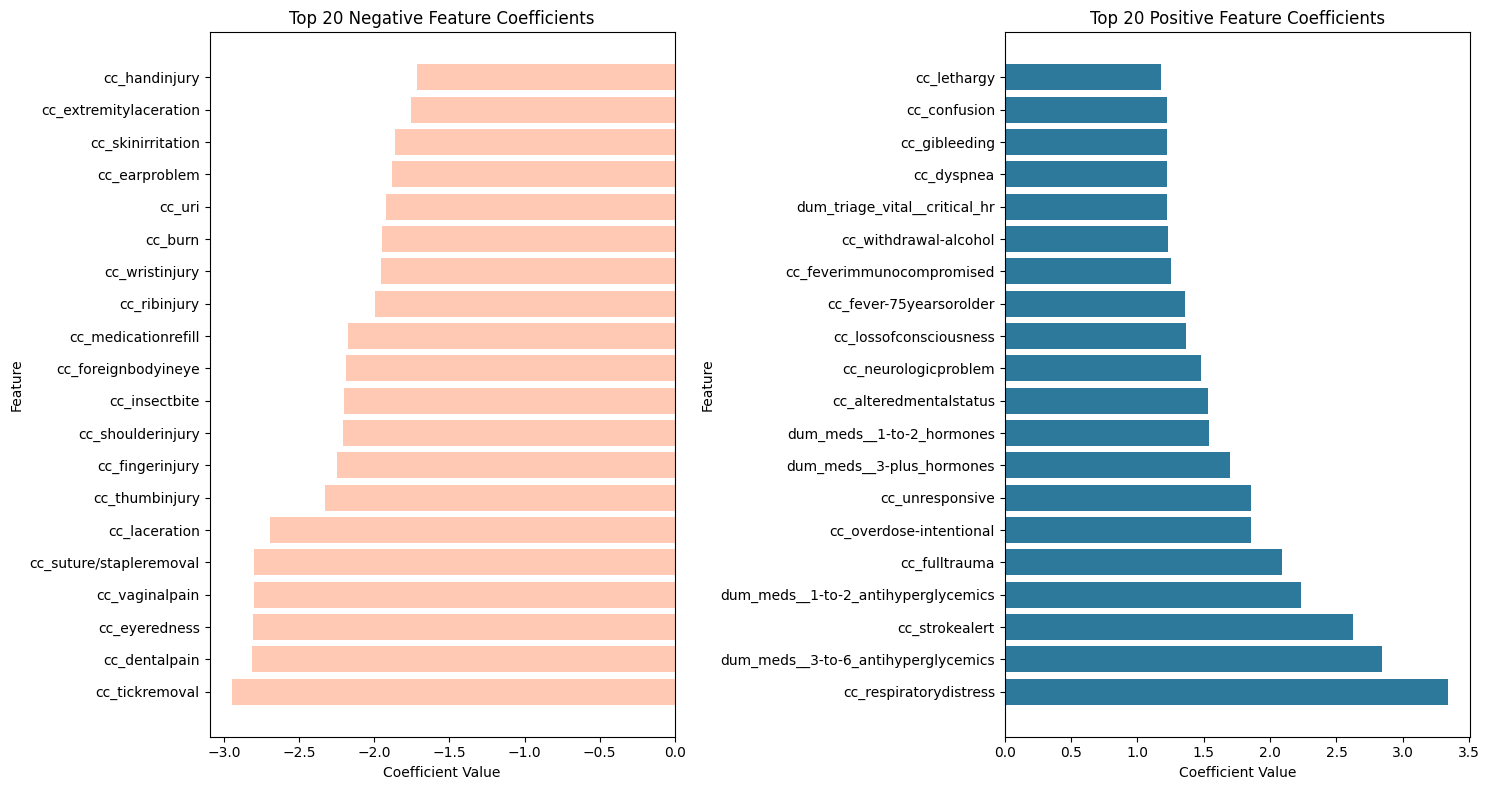

In [163]:
# Get feature coefficients
feature_coefficients = final_logreg_model.coef_[0]

# Get the indices of the top 20 positive features
top20_positive_indices = np.argsort(feature_coefficients)[-20:]

# Get the coefficients for the top 20 positive features
top20_positive_coefficients = feature_coefficients[top20_positive_indices]

# Get the indices of the top 20 negative features
top20_negative_indices = np.argsort(feature_coefficients)[:20][::-1]

# Get the names of the top 20 negative features
top20_negative_features = X_train.columns[top20_negative_indices]

# Get the coefficients for the top 20 negative features
top20_negative_coefficients = feature_coefficients[top20_negative_indices]

# Print the top 20 positive features and their coefficients
print("Top 20 Positive Features:")
for feature, coef in zip(top20_positive_features, top20_positive_coefficients):
    print(f"{feature}: {coef}")

# Print the top 20 negative features and their coefficients
print("\nTop 20 Negative Features:")
for feature, coef in zip(top20_negative_features, top20_negative_coefficients):
    print(f"{feature}: {coef}")

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the top 20 negative coefficients
axes[0].barh(range(len(top20_negative_features)), top20_negative_coefficients, align='center', color='#FFC9B3')
axes[0].set_yticks(range(len(top20_negative_features)))
axes[0].set_yticklabels(top20_negative_features)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Feature')
axes[0].set_title('Top 20 Negative Feature Coefficients')

# Plot the top 20 positive coefficients
axes[1].barh(range(len(top20_positive_features)), top20_positive_coefficients, align='center', color='#2D799C')
axes[1].set_yticks(range(len(top20_positive_features)))
axes[1].set_yticklabels(top20_positive_features)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Feature')
axes[1].set_title('Top 20 Positive Feature Coefficients')

# Invert y-axis for both subplots
axes[0].invert_yaxis()
axes[1].invert_yaxis()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Let's make a smaller more condensed visual for presentation purposes, this time only showing the top 5 features.

Top 5 Positive Features:
cc_fulltrauma: 2.0923409090695273
dum_meds__1-to-2_antihyperglycemics: 2.2361163417980605
cc_strokealert: 2.6281493520329455
dum_meds__3-to-6_antihyperglycemics: 2.846532528282009
cc_respiratorydistress: 3.338848307366643

Top 5 Negative Features:
cc_suture/stapleremoval: -2.7970712045601562
cc_vaginalpain: -2.7987213416764805
cc_eyeredness: -2.807201301172673
cc_dentalpain: -2.812169276308561
cc_tickremoval: -2.948771655373286


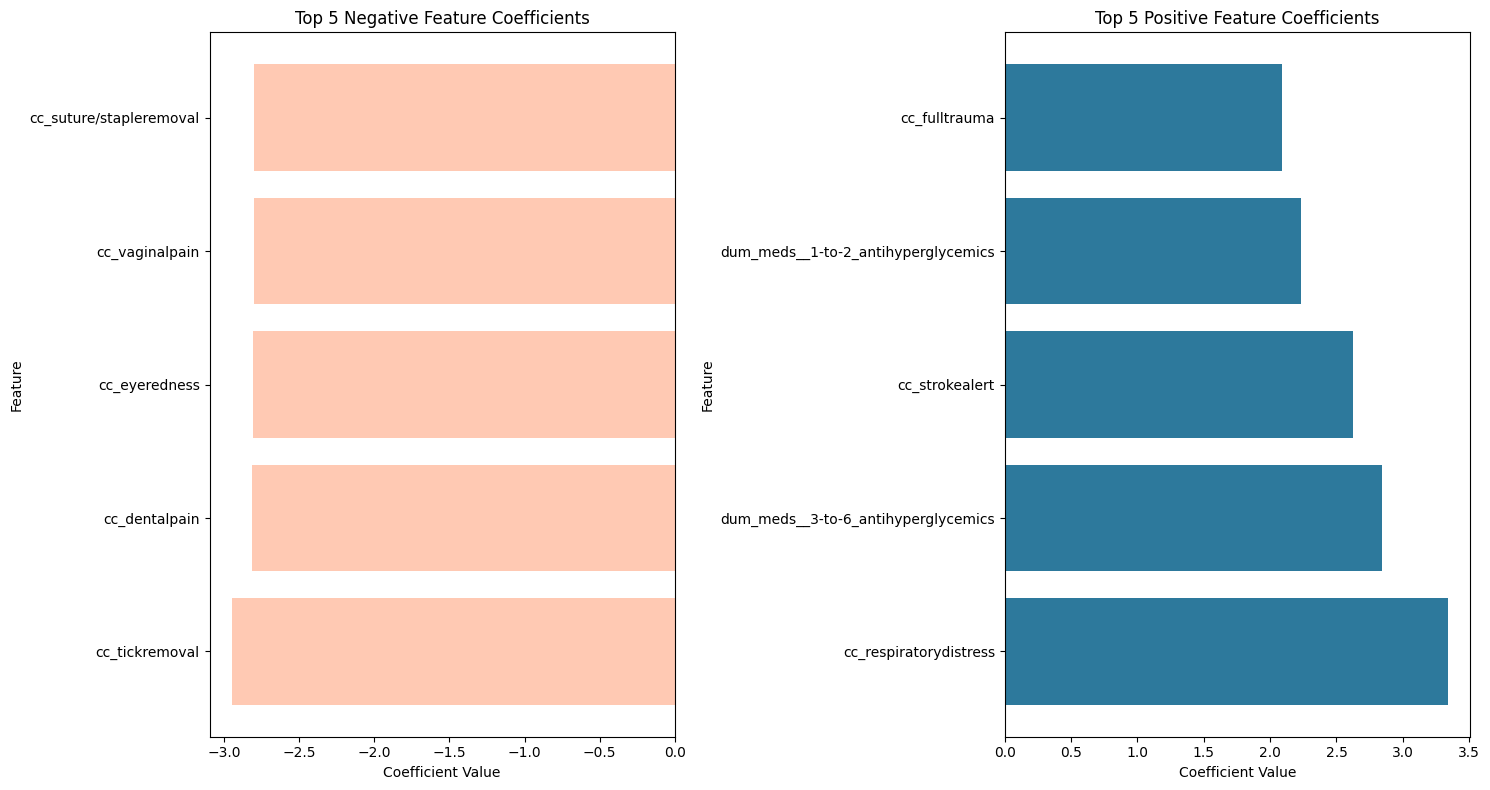

In [164]:
# Get the indices of the top 5 positive features
top5_positive_indices = np.argsort(feature_coefficients)[-5:]

# Get the names of the top 5 positive features
top5_positive_features = X_train.columns[top5_positive_indices]

# Get the coefficients for the top 5 positive features
top5_positive_coefficients = feature_coefficients[top5_positive_indices]

# Get the indices of the top 5 negative features
top5_negative_indices = np.argsort(feature_coefficients)[:5][::-1]

# Get the names of the top 5 negative features
top5_negative_features = X_train.columns[top5_negative_indices]

# Get the coefficients for the top 5 negative features
top5_negative_coefficients = feature_coefficients[top5_negative_indices]

# Print the top 5 positive features and their coefficients
print("Top 5 Positive Features:")
for feature, coef in zip(top5_positive_features, top5_positive_coefficients):
    print(f"{feature}: {coef}")

# Print the top 5 negative features and their coefficients
print("\nTop 5 Negative Features:")
for feature, coef in zip(top5_negative_features, top5_negative_coefficients):
    print(f"{feature}: {coef}")

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot the top 5 negative coefficients
axes[0].barh(range(len(top5_negative_features)), top5_negative_coefficients, align='center', color='#FFC9B3')
axes[0].set_yticks(range(len(top5_negative_features)))
axes[0].set_yticklabels(top5_negative_features)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_ylabel('Feature')
axes[0].set_title('Top 5 Negative Feature Coefficients')

# Plot the top 5 positive coefficients
axes[1].barh(range(len(top5_positive_features)), top5_positive_coefficients, align='center', color='#2D799C')
axes[1].set_yticks(range(len(top5_positive_features)))
axes[1].set_yticklabels(top5_positive_features)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Feature')
axes[1].set_title('Top 5 Positive Feature Coefficients')

# Invert y-axis for both subplots
axes[0].invert_yaxis()
axes[1].invert_yaxis()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


---
#### <a id = 'tree'></a> 1.3 Decision Tree

I plan to also do random forest down the road as an advanced model. It would be a good idea to have a baseline with just a simple decision tree. I will run a base decision tree then run with hyperparameter optimized to see if I can improve it's overall performance. I will continue to use the feature eliminated health-data set. 

Cross-Validation Scores (Train - 5-fold): [0.71232471 0.7091716  0.72236686 0.71556213 0.71071006]
Mean CV Accuracy (Train - 5-fold): 0.7140270730803017

Train Accuracy: 0.9953254991065195

Test Accuracy: 0.7196819085487077

Test Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.75      0.74     11348
           1       0.70      0.69      0.69      9778

    accuracy                           0.72     21126
   macro avg       0.72      0.72      0.72     21126
weighted avg       0.72      0.72      0.72     21126


Confusion Matrix (Test):
 [[8495 2853]
 [3069 6709]]


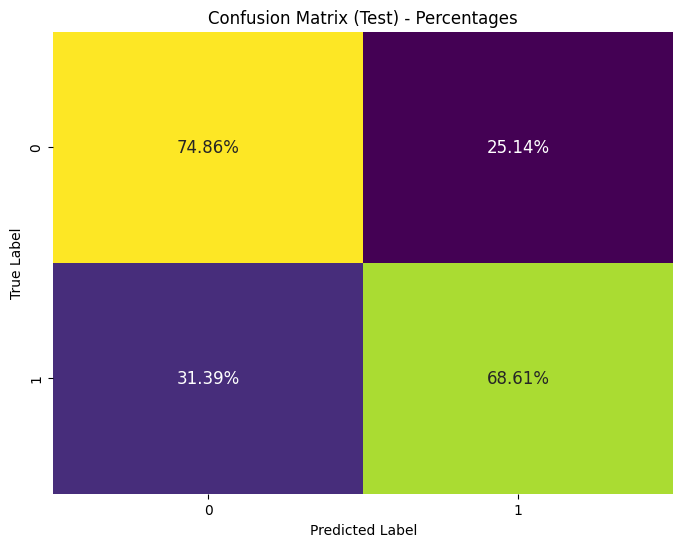

ROC AUC Score: 0.7190313630197
Runtime: 4.82 seconds


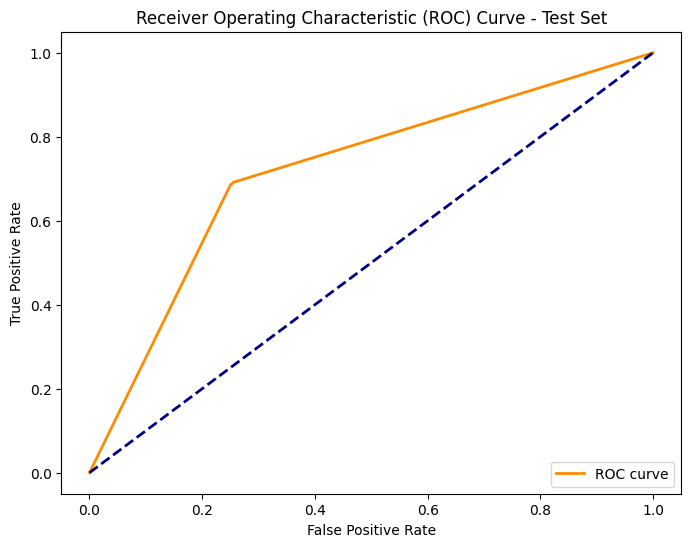

In [130]:
# Record time
start_time = time.time()

# Create a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dt_model.fit(X_train, y_train)

# Record time
end_time = time.time()

# Perform 5-fold cross-validation on the test set
cv_scores_test = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy_test = np.mean(cv_scores_test)
print('Cross-Validation Scores (Train - 5-fold):', cv_scores_test)
print('Mean CV Accuracy (Train - 5-fold):', mean_cv_accuracy_test)

# Predict on the training set
y_train_pred = dt_model.predict(X_train)

# Train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print('\nTrain Accuracy:', train_accuracy)

# Predict on the test set
y_test_pred = dt_model.predict(X_test)

# Test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print('\nTest Accuracy:', test_accuracy)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, dt_model.predict_proba(X_test)[:, 1])

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, dt_model.predict_proba(X_test)[:, 1])
print('ROC AUC Score:', roc_auc)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

Cross-Validation Scores (Train - 5-fold):
- The cross-validation scores range from approximately 0.709 to 0.722, with a mean cross-validation accuracy of around 0.714. These scores indicate that the model's performance is consistent across different training subsets.

Train Accuracy:
- The training accuracy is very high, approximately 0.995. This suggests that the model performs extremely well on the training data, almost achieving perfect accuracy. However, it's likely due to overfitting based on the test accuracy. 

Test Accuracy:
- The accuracy on the test set is approximately 0.720. While still relatively high, there seems to be a drop compared to the training accuracy, indicating some level of overfitting.

Test Classification Report:
- For class 0, precision is 0.73, recall is 0.75, and F1-score is 0.74.
- For class 1, precision is 0.70, recall is 0.69, and F1-score is 0.69.
- The weighted average F1-score is 0.72, and the overall accuracy matches the previously mentioned test set accuracy.


In summary, while the model performs exceptionally well on the training data, there is some evidence of overfitting, as the test accuracy is notably lower. The precision, recall, and F1-score for both classes are reasonable but not as high as the training accuracy might suggest.

----

Now let's try to optimize it's performance with a hyper parameter 

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 18, 'min_samples_split': 18}
Test Accuracy: 0.7559911079803758
Cross-Validation Scores (Train - 5-fold): [0.75137566 0.7552071  0.7604142  0.75556213 0.75739645]
Mean CV Accuracy (Train - 5-fold): 0.7559911079803758

Train Accuracy: 0.8007479201429569

Test Accuracy: 0.7618574268673672

Test Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79     11348
           1       0.77      0.70      0.73      9778

    accuracy                           0.76     21126
   macro avg       0.76      0.76      0.76     21126
weighted avg       0.76      0.76      0.76     21126


Confusion Matrix (Test):
 [[9254 2094]
 [2937 6841]]


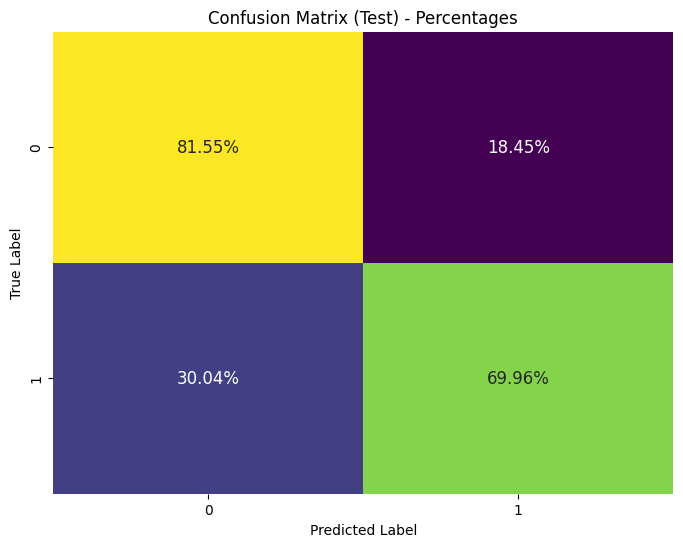

ROC AUC Score: 0.8292228105464038


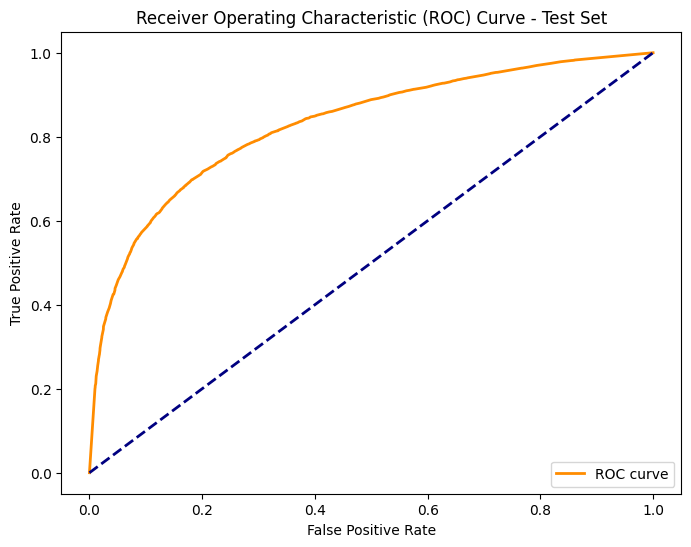

Runtime: 57.86 seconds


In [180]:
#ignoring warnings
warnings.filterwarnings("ignore")

# Record time
start_time = time.time()

# Create a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Define a broader hyperparameter grid with randint for numerical values
param_dist = {
    'max_depth': [None, randint(10, 51)], 
    'min_samples_split': randint(2, 20),   
    'min_samples_leaf': randint(2, 25),   
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

# Use StratifiedKFold for cross-validation with stratified sampling
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV Object
random_search = RandomizedSearchCV(dt_model, param_distributions=param_dist, n_iter=50,
                                   cv=stratified_cv, scoring='accuracy', random_state=42)

# Fit to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", random_search.best_params_)
print("Test Accuracy:", random_search.best_score_)

# Get the best model
best_dt_model = random_search.best_estimator_

# Perform 5-fold cross-validation using StratifiedKFold on the train set
cv_scores = cross_val_score(best_dt_model, X_train, y_train, cv=stratified_cv, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)
print('Cross-Validation Scores (Train - 5-fold):', cv_scores)
print('Mean CV Accuracy (Train - 5-fold):', mean_cv_accuracy)

# Predict on the training set
y_train_pred = best_dt_model.predict(X_train)

# Train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print('\nTrain Accuracy:', train_accuracy)

# Predict on the test set
y_test_pred = best_dt_model.predict(X_test)

# Test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print('\nTest Accuracy:', test_accuracy)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, best_dt_model.predict_proba(X_test)[:, 1])

# Calculate ROC AUC score using the best_dt_model
roc_auc = roc_auc_score(y_test, best_dt_model.predict_proba(X_test)[:, 1])
print('ROC AUC Score:', roc_auc)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Record time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time
print("Runtime: {:.2f} seconds".format(runtime))


Best Parameters:
The hyperparameters selected by the model tuning process are:
'criterion': 'gini'
'max_depth': None
'max_features': None
'min_samples_leaf': 18
'min_samples_split': 18

Cross-Validation Scores on Train Set:
- The cross-validation scores are consistent, ranging from 0.751 to 0.757, with a mean accuracy of approximately 0.756. This suggests that the model is performing consistently well across different folds of the training set.

Train Accuracy:
- The accuracy on the training set is 0.801, indicating how well the model fits the training data.

Test Accuracy:
- The accuracy on the test set is 0.762, suggesting that the model generalizes well to new, unseen data.

Classification Report on Test Set:
- Precision, recall, and F1-score for both classes (0 and 1) are provided. The model performs well, with good balance between precision and recall for both classes.

---

In general the model appears to have good accuracy but the log regression still performs better. But let's do another iteration building on top of the best parameters found since we used RandomSearch and not Gridsearch. This way we can see if there is any way to have an noticeable improvement. 

Best Parameters: {'min_samples_split': 25, 'min_samples_leaf': 25, 'max_features': None, 'max_depth': 15, 'criterion': 'entropy'}
Test Accuracy: 0.76029867775059
Cross-Validation Scores (Test - 5-fold): [0.76100331 0.75218935 0.7460355  0.74272189 0.75242604]
Mean CV Accuracy (Test - 5-fold): 0.7508752187780912

Train Accuracy: 0.7714228233985396

Test Accuracy: 0.762330777241314

Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79     11348
           1       0.79      0.66      0.72      9778

    accuracy                           0.76     21126
   macro avg       0.77      0.76      0.76     21126
weighted avg       0.77      0.76      0.76     21126


Confusion Matrix (Test):
 [[9675 1673]
 [3348 6430]]


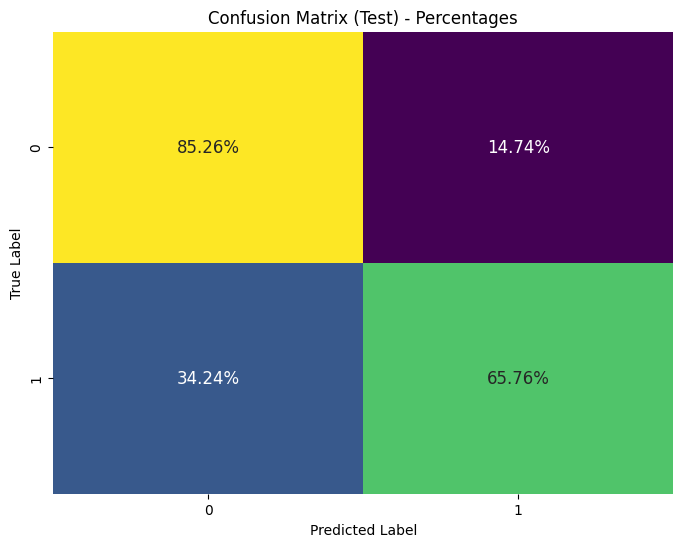

ROC AUC Score: 0.8291176382162686


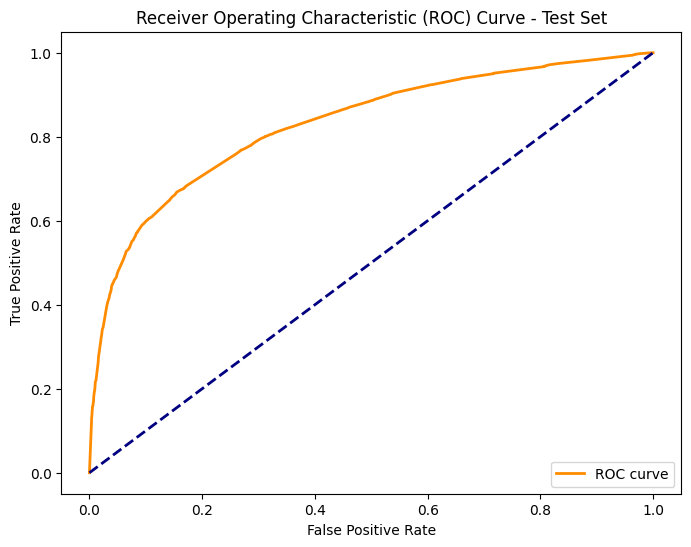

Runtime: 121.31 seconds


In [169]:
# Record time
start_time = time.time()

# Create a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Define a broader hyperparameter grid with randint for numerical values
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'max_features': [None, 'sqrt', 'log2'],
    'min_samples_leaf': [18, 20, 22, 25],
    'min_samples_split': [18, 20, 22, 25]
}

# Use StratifiedKFold for cross-validation with stratified sampling
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV Object
random_search = RandomizedSearchCV(dt_model, param_distributions=param_dist, n_iter=50,
                                   cv=stratified_cv, scoring='accuracy', random_state=42)

# Fit to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", random_search.best_params_)
print("Test Accuracy:", random_search.best_score_)

# Get the best model
best_dt_model = random_search.best_estimator_

# Perform 5-fold cross-validation using StratifiedKFold on the test set
cv_scores_test = cross_val_score(best_dt_model, X_test, y_test, cv=stratified_cv, scoring='accuracy')
mean_cv_accuracy_test = np.mean(cv_scores_test)
print('Cross-Validation Scores (Test - 5-fold):', cv_scores_test)
print('Mean CV Accuracy (Test - 5-fold):', mean_cv_accuracy_test)

# Predict on the training set
y_train_pred = best_dt_model.predict(X_train)

# Train accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print('\nTrain Accuracy:', train_accuracy)

# Predict on the test set
y_test_pred = best_dt_model.predict(X_test)

# Test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print('\nTest Accuracy:', test_accuracy)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, best_dt_model.predict_proba(X_test)[:, 1])

# Calculate ROC AUC score using the best_dt_model
roc_auc = roc_auc_score(y_test, best_dt_model.predict_proba(X_test)[:, 1])
print('ROC AUC Score:', roc_auc)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

# Record time
end_time = time.time()

# Calculate runtime
runtime = end_time - start_time
print('Runtime: {:.2f} seconds'.format(runtime))

The model tuning process has selected the following hyperparameters:
'criterion': 'entropy'
'max_depth': 15
'max_features': None
'min_samples_leaf': 25
'min_samples_split': 25

Cross-Validation Scores on Test Set:
- Cross-validation scores exhibit consistency, ranging from 74.27% to 76.10%, with a mean accuracy of approximately 75.09%. This suggests a stable performance across different folds of the test set.

Train Accuracy:
- The model achieves a training accuracy of 77.14%, reflecting its fit to the training data.

Test Accuracy:
- With an accuracy of 76.03% on the test set, the model demonstrates good generalization to new, unseen data.

Classification Report on Test Set:
- Precision, recall, and F1-score are presented for both classes (0 and 1). Class 0 predictions show high precision, recall, and F1-score. Class 1 predictions exhibit slightly lower recall compared to precision.

The AUC-ROC score is 0.82, providing an aggregate measure of the model's performance across different threshold settings.

In summary, the model demonstrates good accuracy, particularly excelling in predicting Class 0. However, there is room for improvement in predicting Class 1. Considering that logistic regression outperforms this model, further iterations building on the best parameters may uncover opportunities for enhancement

--- 



Top 20 Features and Their Importance Values:
Feature: dum_meds__1-to-2_antihyperglycemics, Importance Value: 0.3826980786625804
Feature: dum_meds__3-to-6_antihyperglycemics, Importance Value: 0.14372918138293075
Feature: demo_employstatus_Employed, Importance Value: 0.06587772237292212
Feature: dum_meds__1-to-2_hormones, Importance Value: 0.04645421028890939
Feature: pmh_chrkidneydisease, Importance Value: 0.034981522536193896
Feature: cc_shortnessofbreath, Importance Value: 0.03425880695006004
Feature: demo_race, Importance Value: 0.026691999944999125
Feature: cc_alteredmentalstatus, Importance Value: 0.024817715724788237
Feature: cc_chestpain, Importance Value: 0.022014855984886252
Feature: pmh_chfnonhp, Importance Value: 0.013140000481405555
Feature: pmh_coronathero, Importance Value: 0.01286606425320988
Feature: dum_triage_vital__hypertension(high)_sbp, Importance Value: 0.012203145651647637
Feature: cc_abdominalpain, Importance Value: 0.009636440504124613
Feature: dum_triage_vital

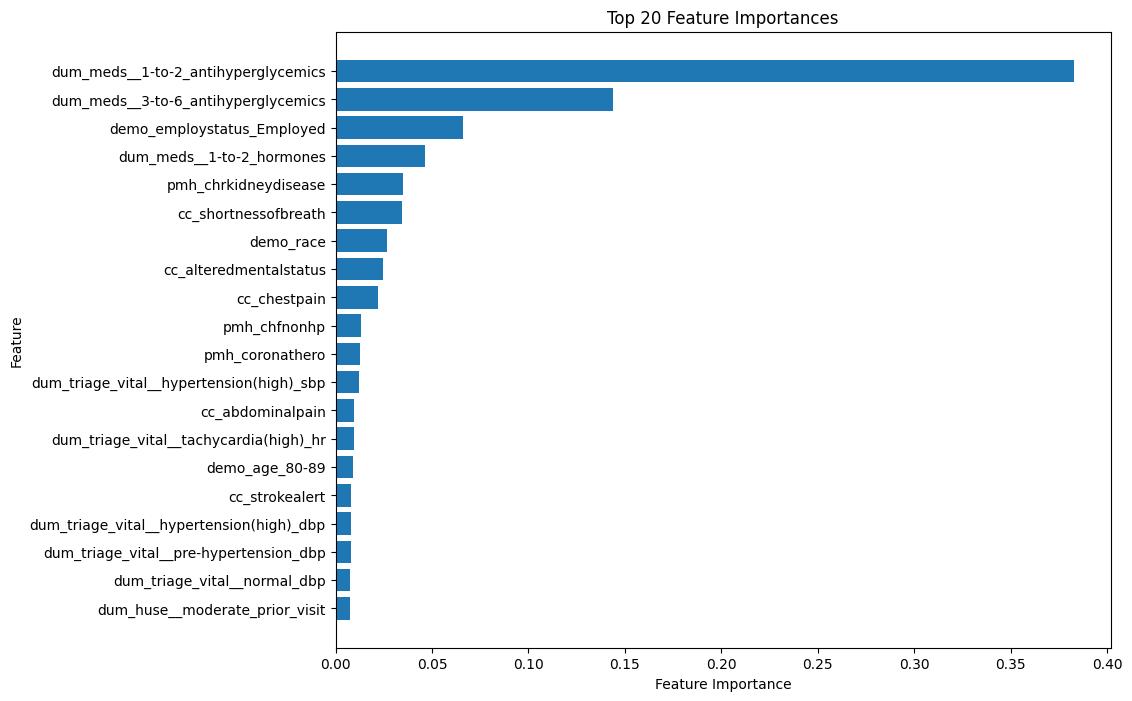

In [175]:
# Fit to the training data
best_dt_model.fit(X_train, y_train)

# Get feature importances
feature_importances = best_dt_model.feature_importances_

# Get the indices of the top 20 features
top20_indices = np.argsort(feature_importances)[-20:]

# Get the names of the top 20 features
top20_features = X_train.columns[top20_indices]

# Print top 20 features and their importance values
print("Top 20 Features and Their Importance Values:")
for feature, importance_value in zip(top20_features[::-1], feature_importances[top20_indices][::-1]):
    print(f"Feature: {feature}, Importance Value: {importance_value}")

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(top20_features)), feature_importances[top20_indices], align='center')
plt.yticks(range(len(top20_features)), top20_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.show()


---
### <a id = 'conc'></a> Conclusion

Now that we have ran our basic models and optimized them, we can see that in general they perform pretty similarly with logistic regression performing slightly better in comparison to decision tree. Even after running several iterations to optimize performance, the accuracy score hovers around 80%. We will now export these base models so that they can be used on new unseen data. 

The model for logistic regression

In [165]:
from joblib import dump, load

# Save the model
dump(best_logreg_model, 'KLO_BStn_LogReg.joblib')


['KLO_BStn_LogReg.joblib']

The model for Decision Tree

In [176]:
from joblib import dump, load

# Save the model
dump(best_dt_model, 'KLO_BStn_DTree.joblib')



['KLO_BStn_DTree.joblib']

In [ ]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 419 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int8(419)
memory usage: 42.2 MB


As we will continue our advanced model in a separate notebook, we will export another CSV file.

In [177]:
health_data.to_csv('clean_health_data_pt3.csv', index=False) 

----